In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import yaml

In [2]:
auxs = ["rkl", "l2", "bisim_critic"]

envs = []
with open("envs.txt", "r") as envs_file:
    for line in envs_file:
        stripped = line.strip()
        if stripped != "":
            envs.append(stripped)

results = dict()

In [3]:
new_auxs = []
new_cfg_paths = glob.glob("./logs/**/flags.yml", recursive=True)
for cfg_path in new_cfg_paths:
    res_path = cfg_path.replace("flags.yml", "progress.csv")
    with open(cfg_path, "r") as cfg_file:
        cfg = yaml.safe_load(cfg_file)

        env = cfg["id"]
        aux = cfg["aux"]
        df = pd.read_csv(res_path)

        if aux == "bisim_critic":
            if "bisim_critic" in cfg["lr"]:
                bisim_lr = cfg["lr"]["bisim_critic"]
            else:
                bisim_lr = cfg["lr"]["model"]
            bisim_critic_train_steps = cfg["bisim_critic_train_steps"]
            aux = aux + "_" + str(bisim_critic_train_steps) + "_" + str(bisim_lr)
            if aux not in new_auxs:
                new_auxs.append(aux)
        else:
            if aux not in new_auxs:
                new_auxs.append(aux)

        if env not in results:
            results[env] = dict()
        if aux not in results[env]:
            results[env][aux] = []
        results[env][aux].append(df)
auxs = sorted(new_auxs)
auxs

['bisim',
 'bisim_critic_10_0.0001',
 'bisim_critic_1_0.0001',
 'bisim_critic_1_0.0004',
 'bisim_critic_1_4e-05',
 'bisim_critic_20_0.0001',
 'bisim_critic_5_0.0001',
 'l2',
 'op-kl',
 'op-l2',
 'rkl']

In [4]:
len(new_cfg_paths)

49

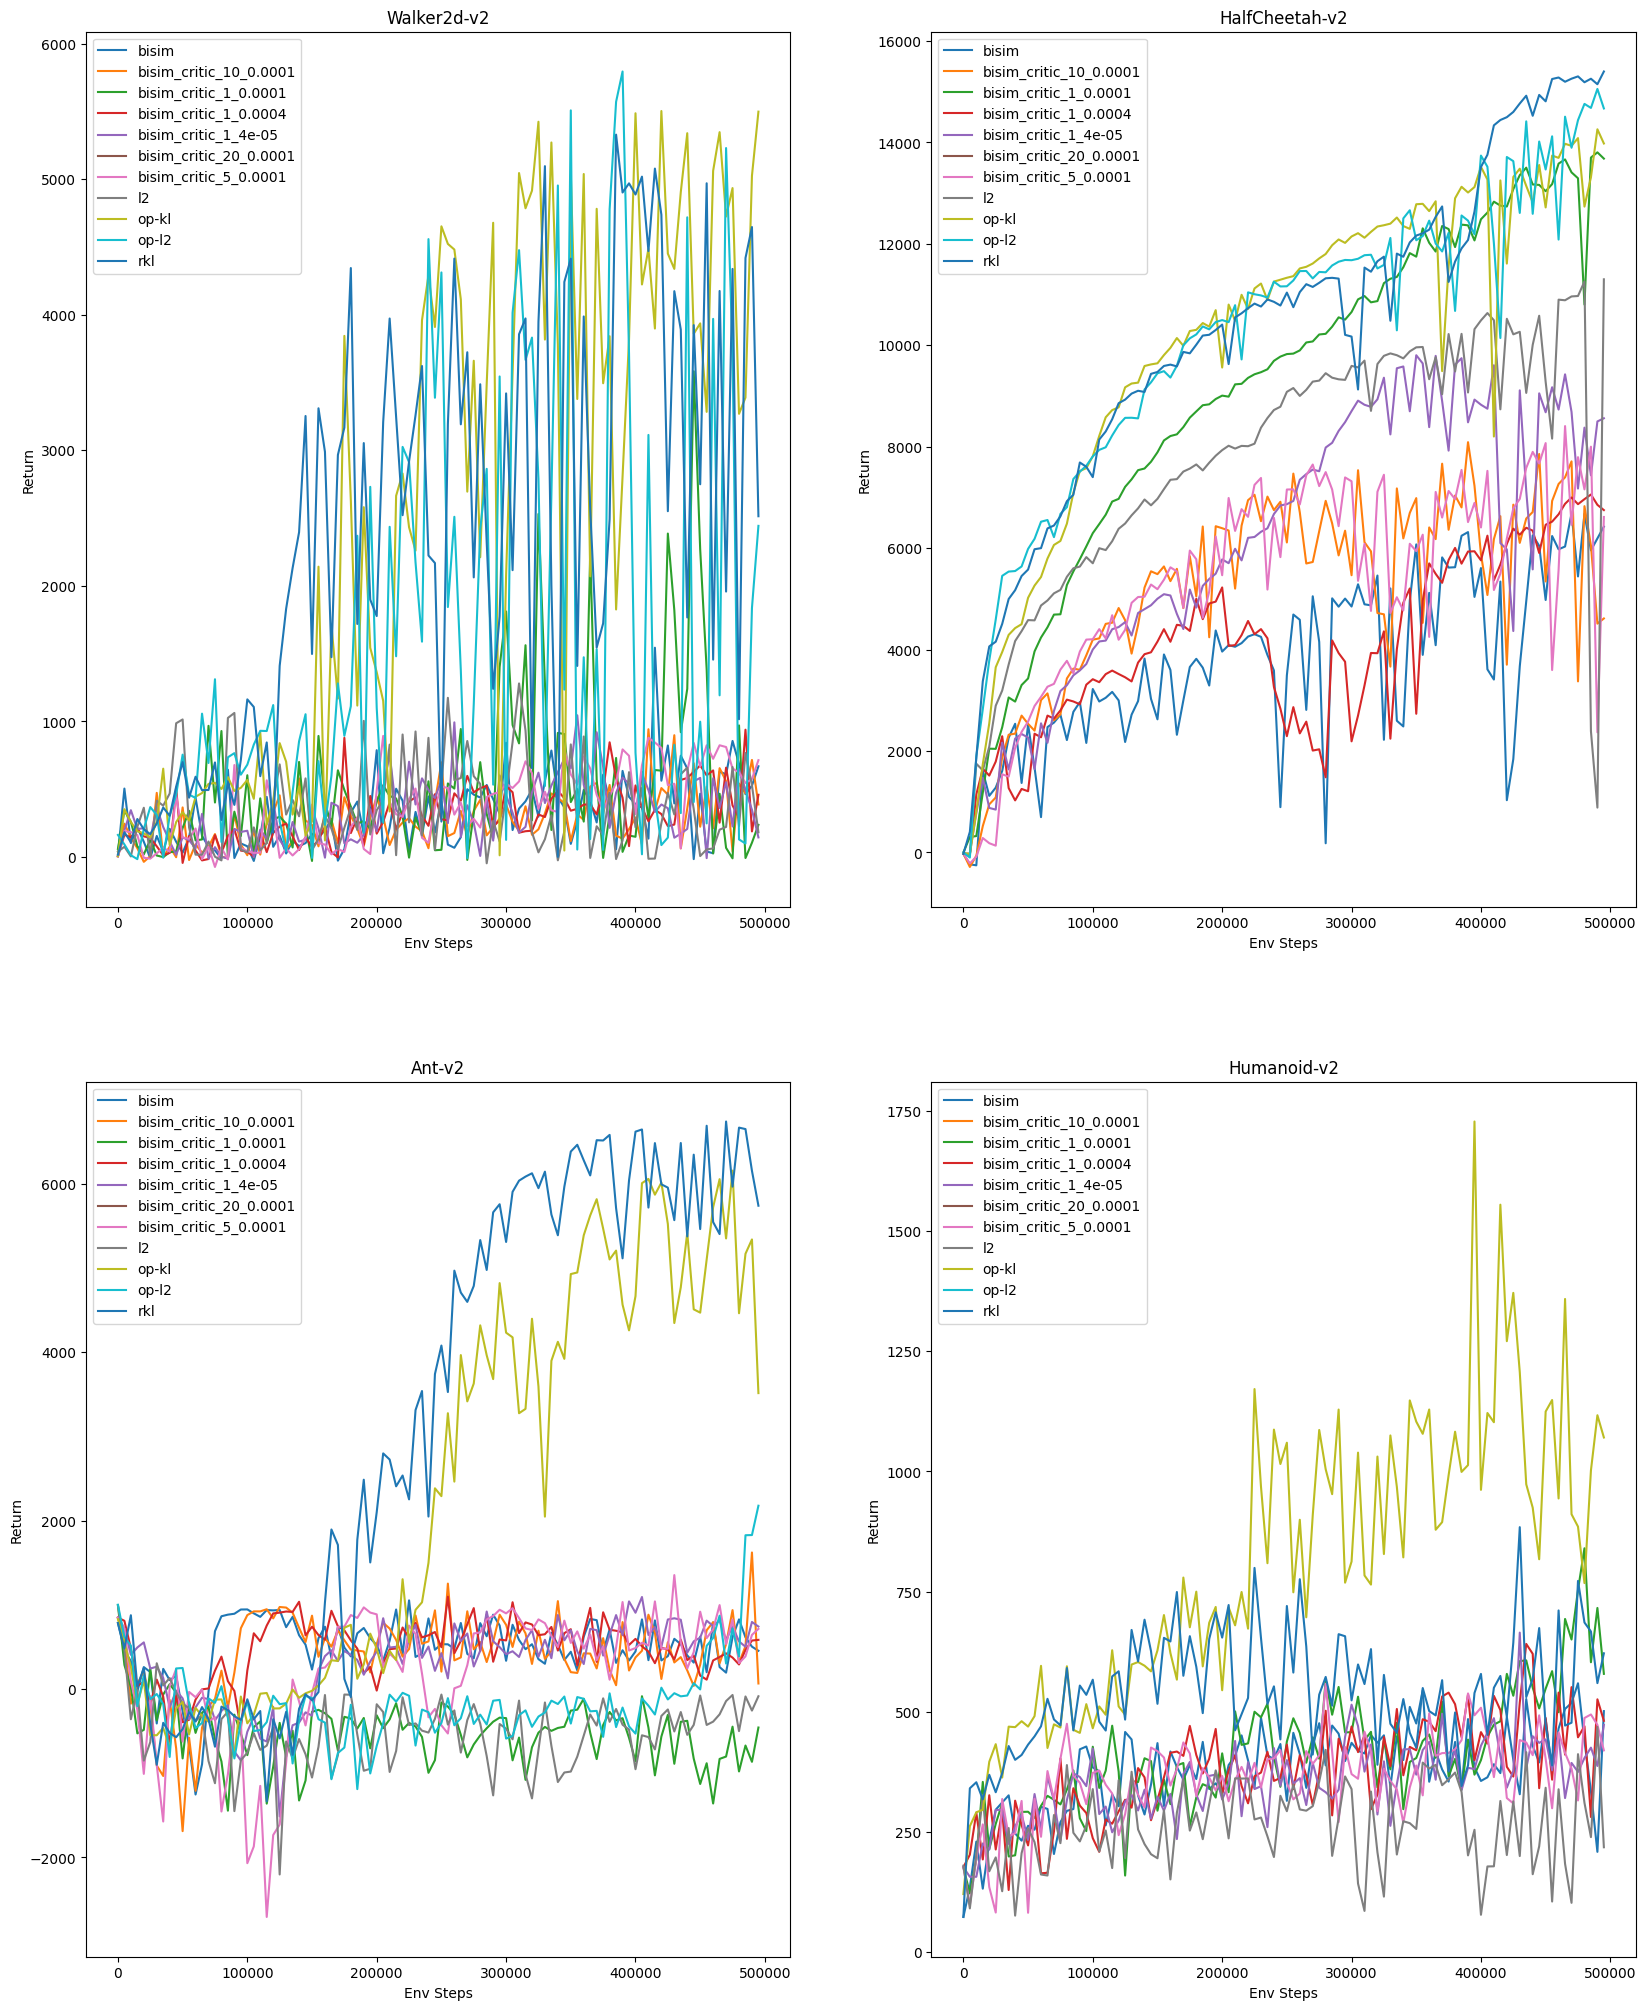

In [5]:
plt.figure(figsize=(20, 25))
i = 1
for env in envs:
    plt.subplot(2, 2, i)
    legend_elems = []
    for aux in auxs:
        if not (env in results and aux in results[env]):
            continue
        legend_elems.append(aux)
        
        dfs = results[env][aux]
        if len(dfs) == 1:
            df = dfs[0]
        else:
            combined = pd.concat(
                [df[["env_steps", "return"]] for df in dfs], ignore_index=True
            )

            def iqm(x):
                q1, q3 = np.percentile(x, [25, 75])
                mask = (x >= q1) & (x <= q3)
                return np.mean(x[mask]) if len(x[mask]) > 0 else np.nan

            df = (
                combined.groupby("env_steps")["return"]
                .agg(iqm)
                .reset_index()
                .sort_values("env_steps")
            )

        valid_idxs = ~df["return"].isna() 
        plt.plot(df[valid_idxs]["env_steps"], df[valid_idxs]["return"])

    plt.xlabel("Env Steps")
    plt.ylabel("Return")
    plt.title(env)

    plt.legend(legend_elems)

    i += 1
plt.show()